In [1]:
import os
import pandas as pd
import numpy as np
import nltk
import string
import re
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import seaborn as sn
import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

from sklearn.preprocessing import LabelEncoder
from seaborn import heatmap
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import recall_score

!pip install 'neptune-contrib[monitoring]>=0.24.9'
import neptune

from neptunecontrib.monitoring.xgboost_monitor import neptune_callback
neptune.init('shared/XGBoost-integration',
             api_token='ANONYMOUS')

/usr/local/lib/python3.7/dist-packages/neptunecontrib/monitoring/xgboost_monitor.py:21: UserWarning: neptunecontrib.monitoring.xgboost_monitor was moved to neptunecontrib.monitoring.xgboost
neptunecontrib.monitoring.xgboost_monitor will be removed in future releases.

  warnings.warn(message)


Project(shared/XGBoost-integration)

In [2]:
string.punctuation
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
dataset1 = pd.read_csv("/content/twitter15-dataset.csv", delimiter=',')
dataset2 = pd.read_csv("/content/twitter16-dataset.csv", delimiter=',')
rumor_df = pd.concat([dataset1, dataset2])
pd.set_option('display.max_colwidth' , 300)
print(rumor_df.shape)
rumor_df.head(20)

(1733, 2)


post      label
0                               america is a nation of second chances —@potus on new reforms to solitary confinement: URL URL  non-rumor
1                        brandon marshall visits and offers advice, support to brother of fallen hero zaevion dobson: URL URL  non-rumor
2                          rip elly may clampett: so sad to learn #beverlyhillbillies star donna douglas has passed away. URL      rumor
3                             former 3 doors down guitarist matt roberts has died at age 38, according to his father. URL URL  non-rumor
4                                    just in: missing afghan soldiers found trying to enter canada near niagara falls URL URL      rumor
5                                                         #riphulkhogan my heart is ripping like your shirt. wwe'll miss you.      rumor
6                                           a chick-fil-a manager allegedly banned this hilarious list of slang words URL URL      rumor
7                                   islamic tribunal using sharia law in texas has been confirmed URL @breitbartnews #a4a URL      rumor
8                             alpha male rt @marc_leibowitz: photo of vladimir putin's motorcade. posted without comment. URL      rumor
9                       เผยกบฏยูเครนอาจเข้าใจผิดคิดว่า #mh17 เป็นเครื่องบินทหารยูเครนรุกล้ำ / 14 ก.ค.ก็เพิ่งยิงตกไปลำ URL URL      rumor
10                                 report: more american fifth-graders taking gap year to unwind before middle school URL URL  non-rumor
11                                                     report: amazon plans to open its first physical store, in new york URL      rumor
12                         ‘keep it,’ says simone biles throwing gold medal to adoring men's gymnastics team URL #rio2016 URL  non-rumor
13  let's let our friends know that a state senator in south carolina stated "women are a lesser cut of meat" #chewonthis URL      rumor
14       a traditional beer that authorities believe was poisoned with crocodile bile has killed 56 people in mozambique: URL      rumor
15                               nothing to see here. just nuggets forward wilson chandler catching a 350-pound fish: URL URL  non-rumor
16          police chief helric fredou, one of the police officers investigating the case #charliehebdo, commits suicide. URL      rumor
17                                                                seriously? racist mcdonald’s sign is obviously a hoax - URL      rumor
18       several in critical condition - one in a coma - after clinical trial of new drug in france, health minister says URL  non-rumor
19                                                          omfg read this its my personal experience with talking angela URL      rumor

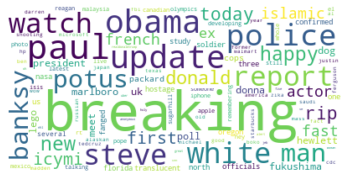

In [4]:
from wordcloud import WordCloud

#Checking for NaN values
rumor_df.isna().sum()
#Removing NaN Values
#df.dropna(inplace = True)
#Creating the text variable
text = " ".join(cat.split()[0] for cat in rumor_df.post)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [5]:
def clean_text(txt):
  remove_pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
  txt = remove_pattern.sub('', str(txt))
  txt = "".join([c for c in txt if c not in string.punctuation])
  remove_emoji = re.compile("["
                    u"\U0001F600-\U0001FFFF"  # emoticons
                    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                    u"\U0001F680-\U0001F6FF"  # transport & map symbols
                    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                    u"\U00002702-\U000027B0"
                    u"\U000024C2-\U0001F251"
                    "]+", flags=re.UNICODE)
  txt = remove_emoji.sub(r'', txt)
  tokens = word_tokenize(txt.lower())
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  words = [word for word in stripped if word.isalpha()]
  txt = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords]
  return txt

rumor_df['cleanpost'] = rumor_df['post'].apply(lambda x: clean_text(x))

rumor_df=rumor_df.replace(to_replace="non-rumor",value="1")
rumor_df=rumor_df.replace(to_replace="rumor",value="0")


# mapping = {'real': 1, 'false': 2}
# rumor_df.replace({'real': mapping, 'false': mapping})

# fakeOrreal = {'rumor' : 0 , 'non-rumor' : 1 }
# rumor_df['label'] = rumor_df['label'].map(fakeOrreal)
rumor_df.head()

post  ...                                                                                             cleanpost
0         america is a nation of second chances —@potus on new reforms to solitary confinement: URL URL  ...               [america, nation, second, chance, —potus, new, reform, solitary, confinement, url, url]
1  brandon marshall visits and offers advice, support to brother of fallen hero zaevion dobson: URL URL  ...  [brandon, marshall, visit, offer, advice, support, brother, fallen, hero, zaevion, dobson, url, url]
2    rip elly may clampett: so sad to learn #beverlyhillbillies star donna douglas has passed away. URL  ...   [rip, elly, may, clampett, sad, learn, beverlyhillbillies, star, donna, douglas, passed, away, url]
3       former 3 doors down guitarist matt roberts has died at age 38, according to his father. URL URL  ...                [former, 3, door, guitarist, matt, robert, died, age, 38, according, father, url, url]
4              just in: missing afghan soldiers found trying to enter canada near niagara falls URL URL  ...               [missing, afghan, soldier, found, trying, enter, canada, near, niagara, fall, url, url]

[5 rows x 3 columns]

In [ ]:
# rumor_df['cleanpost']=rumor_df['cleanpost'].apply(str)
# def string_text(txt):
#   string = "".join(txt)
#   rumor_df['cleanpost'] = rumor_df['cleanpost'].apply(lambda x: string_text(x))

In [ ]:
# import scipy.sparse
# Vectorizer1 = TfidfVectorizer(analyzer=clean_text)
# tfidf = Vectorizer1.fit_transform(rumor_df['cleanpost'])
# Vectorizer2 = CountVectorizer(ngram_range=(1,1), stop_words='english')
# bow = Vectorizer2.fit_transform(rumor_df['cleanpost'])
# vec = scipy.sparse.hstack([tfidf, bow])

# df =  pd.DataFrame(vec.toarray())
# rumor_df.head(20)

In [ ]:
rumor_df.label.unique()

array(['1', '0'], dtype=object)

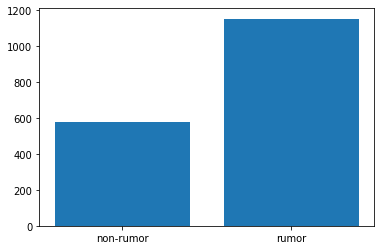

In [6]:
classes = rumor_df.label.unique()
counts = []

for i in classes:
  count = len(rumor_df[rumor_df.label==i])
  counts.append(count)

plt.bar(['non-rumor', 'rumor'], counts)
plt.show()


In [8]:
Vectorizer1 = TfidfVectorizer(analyzer=clean_text)
tfidf = Vectorizer1.fit_transform(rumor_df['cleanpost'])
print(tfidf.shape)
# df = pd.DataFrame(tfidf.toarray(), columns = Vectorizer1.get_feature_names())


(1733, 4830)


In [9]:
data = rumor_df["cleanpost"]
label = rumor_df["label"]
label = pd.factorize(rumor_df['label'])[0].reshape(-1, 1) 
[data_train, data_test, label_train, label_test] = train_test_split(tfidf, label, test_size=0.25, random_state=2, stratify=label)

In [10]:
from sklearn. preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
data_train = sc.fit_transform(data_train)
data_test = sc.transform(data_test)

In [ ]:
from xgboost import XGBClassifier

#1m 8s
# fit model 
xgb_model = XGBClassifier(learning_rate=0.15, max_depth=8, n_estimators=300, nthread=-1, silent=True, subsample=0.9)
xgb_model.fit(data_train, label_train)

# make predictions for test data
label_pred1 = xgb_model.predict(data_test)
xgb_predictions = [round(value) for value in label_pred1]

In [ ]:
#evaluate predictions

#accuracy
xgb_accuracy = accuracy_score(label_test, xgb_predictions)
print("Accuracy using XGBoost: %.2f%%" % (xgb_accuracy * 100.0))

#recall
from sklearn.metrics import recall_score
xgb_recall = recall_score(label_test, xgb_predictions)
print("Recall for XGB: ", xgb_recall)

#precision
from sklearn.metrics import precision_score
xgb_precision = precision_score(label_test, xgb_predictions, average=None)
print("Precision for XGB: ", xgb_precision)

#F1 Score
from sklearn.metrics import f1_score
xgb_f1score = f1_score(label_test, xgb_predictions, average=None)
print("F1 Score for XGB: ", xgb_f1score)

#manual f1 score
xgb_F1 = 2* (xgb_precision * xgb_recall) / (xgb_precision + xgb_recall)
print("Manual F1 score for XGB: ", xgb_F1)

Accuracy using XGBoost: 78.11%
Recall for XGB:  0.8581314878892734
Precision for XGB:  [0.68939394 0.82119205]
F1 Score for XGB:  [0.65703971 0.8392555 ]
Manual F1 score for XGB:  [0.76456339 0.8392555 ]


Confusion Matrix for XGBoost: 
 [[ 91  54]
 [ 41 248]]


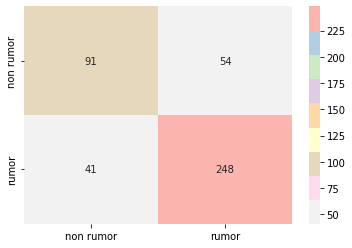

In [ ]:
xgb_conmat = confusion_matrix(label_test, xgb_predictions)
print("Confusion Matrix for XGBoost: " + "\n" , xgb_conmat)

heatmap(xgb_conmat , cmap="Pastel1_r", xticklabels=['non rumor' ,'rumor'], yticklabels=['non rumor' ,'rumor'], annot=True, fmt='g')

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 7.4 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=f50fb187d804bf2891ab7e29d2f0193fcdc645542140521f95280d104acbb18b
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(Vectorizer1, xgb_model)
rumor_df.post.iloc[0]
print(pipe.predict_proba([rumor_df.post.iloc[0]]))
pipe = make_pipeline(Vectorizer1, xgb_model)
rumor_df.post.iloc[0]
print(pipe.predict_proba([rumor_df.post.iloc[0]]))

from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=["non rumor", "rumor"])
max_features = rumor_df.post.str.split().map(lambda x: len(x)).max() 
print("Maximum number of features: ", max_features)
import random
random.seed(20)
idx = random.randint(0, len(rumor_df))
exp1 = explainer.explain_instance(
    rumor_df.post.iloc[idx], pipe.predict_proba, num_features=7
    
)
print(f"Explanation as a list of weighted features: ")
exp1.as_list()


[[0.9801198 0.0198802]]
[[0.9801198 0.0198802]]
Maximum number of features:  29
Explanation as a list of weighted features: 


[('URL', -0.5287391213668025),
 ('picture', 0.007625212608033024),
 ('gunman', 0.007473332962917989),
 ('seven', 0.00740851795993568),
 ('according', 0.007353934283118938),
 ('this', 0.0009026194353820475),
 ('a', 0.0006660938716001685)]

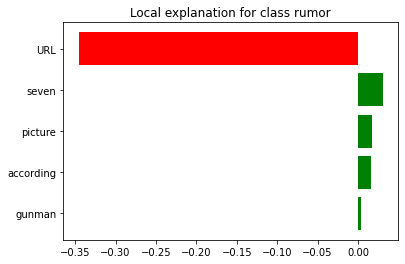

In [ ]:
plot = exp1.as_pyplot_figure()

In [ ]:
exp1.show_in_notebook(text=False)

In [ ]:
from sklearn.svm import SVC

#16s
# fit model 
svc = SVC(kernel="linear", C=1.0, random_state=27, probability=True)
svc.fit(data_train, label_train)

# make predictions for test data 
label_pred2 = svc.predict(data_test)
svc_predictions = [round(value) for value in label_pred2]

In [ ]:
#evaluate predictions

#accuracy
svc_accuracy = accuracy_score(label_test, svc_predictions)
print("Accuracy using Support Vector Machine: %.2f%%" % (svc_accuracy * 100.0))

#recall
from sklearn.metrics import recall_score
svc_recall = recall_score(label_test, svc_predictions)
print("Recall for SVM: ", svc_recall)

#precision
from sklearn.metrics import precision_score
svc_precision = precision_score(label_test, svc_predictions, average=None)
print("Precision for SVM: ", svc_precision)

#F1 Score
from sklearn.metrics import f1_score
svc_f1score = f1_score(label_test, svc_predictions, average=None)
print("F1 Score for SVM: ", svc_f1score)

#manual f1 score
svc_F1 = 2* (svc_precision * svc_recall) / (svc_precision + svc_recall)
print("Manual F1 score for SVM: ", svc_F1)

Accuracy using Support Vector Machine: 81.57%
Recall for SVM:  0.9480968858131488
Precision for SVM:  [0.84210526 0.80825959]
F1 Score for SVM:  [0.66666667 0.87261146]
Manual F1 score for SVM:  [0.89196338 0.87261146]


In [ ]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(Vectorizer1, svc)
rumor_df.post.iloc[0]
print(pipe.predict_proba([rumor_df.post.iloc[0]]))

from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=["non rumor", "rumor"])
max_features = rumor_df.post.str.split().map(lambda x: len(x)).max() 
print("Maximum number of features: ", max_features)
import random
random.seed(20)
idx = random.randint(0, len(rumor_df))
exp2 = explainer.explain_instance(
    rumor_df.post.iloc[idx], pipe.predict_proba, num_features=7
    
)
print(f"Explanation as a list of weighted features: ")
exp2.as_list()

[[0.4134404 0.5865596]]
Maximum number of features:  29
Explanation as a list of weighted features: 


[('seven', -0.010646962974796781),
 ('gunman', 0.009219801869029329),
 ('picture', 0.0070109441992694315),
 ('URL', -0.006567483153646741),
 ('according', 0.0015938555191426164),
 ('is', 0.00016582275797943544),
 ('this', -0.0001579219906148954)]

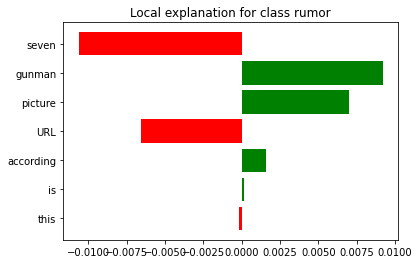

In [ ]:
plot = exp2.as_pyplot_figure()

In [ ]:
exp2.show_in_notebook(text=False)

Confusion Matrix for Support Vector Machine: 
 [[ 80  65]
 [ 15 274]]


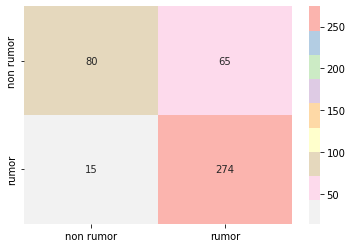

In [ ]:
svc_conmat = confusion_matrix(label_test, svc_predictions)
print("Confusion Matrix for Support Vector Machine: " + "\n", svc_conmat)

heatmap(svc_conmat , cmap="Pastel1_r", xticklabels=['non rumor' ,'rumor'], yticklabels=['non rumor' ,'rumor',], annot=True, fmt='g')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 300, max_depth = 300, random_state = 27)
rf.fit(data_train,label_train)
label_pred1 = rf.predict(data_test)
rf_predictions = [round(value) for value in label_pred1]

In [ ]:
#evaluate predictions

#accuracy
rf_accuracy = accuracy_score(label_test, rf_predictions)
print("Accuracy using RF: %.2f%%" % (rf_accuracy * 100.0))

#recall
from sklearn.metrics import recall_score
rf_recall = recall_score(label_test, rf_predictions)
print("Recall for RF: ", rf_recall)

#precision
from sklearn.metrics import precision_score
rf_precision = precision_score(label_test, rf_predictions, average=None)
print("Precision for RF: ", rf_precision)

#F1 Score
from sklearn.metrics import f1_score
rf_f1score = f1_score(label_test, rf_predictions, average=None)
print("F1 Score for RF: ", rf_f1score)

#manual f1 score
rf_F1 = 2* (rf_precision * rf_recall) / (rf_precision + rf_recall)
print("Manual F1 score for RF: ", rf_F1)

Accuracy using RF: 75.81%
Recall for RF:  0.9896193771626297
Precision for RF:  [0.93478261 0.7371134 ]
F1 Score for RF:  [0.45026178 0.84490399]
Manual F1 score for RF:  [0.96141969 0.84490399]


Confusion Matrix for Random Forest: 
 [[ 43 102]
 [  3 286]]


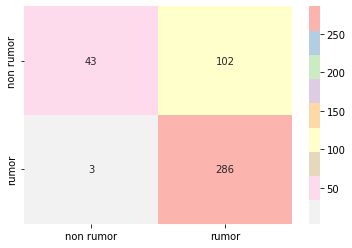

In [ ]:
rf_conmat = confusion_matrix(label_test, rf_predictions)
print("Confusion Matrix for Random Forest: " + "\n" , rf_conmat)

heatmap(rf_conmat , cmap="Pastel1_r", xticklabels=['non rumor' ,'rumor'], yticklabels=['non rumor' ,'rumor'], annot=True, fmt='g')

In [ ]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(Vectorizer1, rf)
rumor_df.post.iloc[0]
print(pipe.predict_proba([rumor_df.post.iloc[0]]))
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=["non rumor", "rumor"])
max_features = rumor_df.post.str.split().map(lambda x: len(x)).max() 
print("Maximum number of features: ", max_features)
import random
random.seed(20)
idx = random.randint(0, len(rumor_df))
exp3 = explainer.explain_instance(
    rumor_df.post.iloc[idx], pipe.predict_proba, num_features=7
    
)
print(f"Explanation as a list of weighted features: ")
exp3.as_list()

[[0.00666667 0.99333333]]
Maximum number of features:  29
Explanation as a list of weighted features: 


[('seven', 0.0051008559965557915),
 ('gunman', 0.004827284957469731),
 ('according', 0.004753803653181649),
 ('picture', 0.004599404708450997),
 ('URL', -0.004519793336362566),
 ('a', 0.0004116911199946018),
 ('is', 0.0003968896519979612)]

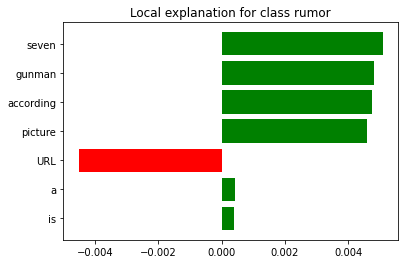

In [ ]:
plot = exp3.as_pyplot_figure()

In [ ]:
exp3.show_in_notebook(text=False)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators = 300, max_depth = 300, random_state = 27)
etc.fit(data_train,label_train)
label_pred1 = etc.predict(data_test)
etc_predictions = [round(value) for value in label_pred1]

In [ ]:
#evaluate predictions

#accuracy
etc_accuracy = accuracy_score(label_test, etc_predictions)
print("Accuracy using ETC: %.2f%%" % (etc_accuracy * 100.0))

#recall
from sklearn.metrics import recall_score
etc_recall = recall_score(label_test, etc_predictions)
print("Recall for ETC: ", etc_recall)

#precision
from sklearn.metrics import precision_score
etc_precision = precision_score(label_test, etc_predictions, average=None)
print("Precision for ETC: ", etc_precision)

#F1 Score
from sklearn.metrics import f1_score
etc_f1score = f1_score(label_test, etc_predictions, average=None)
print("F1 Score for ETC: ", rf_f1score)

#manual f1 score
etc_F1 = 2* (etc_precision * etc_recall) / (etc_precision + etc_recall)
print("Manual F1 score for ETC: ", etc_F1)

Accuracy using ETC: 77.88%
Recall for ETC:  0.972318339100346
Precision for ETC:  [0.87692308 0.76151762]
F1 Score for ETC:  [0.45026178 0.84490399]
Manual F1 score for ETC:  [0.92216017 0.85410334]


Confusion Matrix for Extra Trees Classifer: 
 [[ 57  88]
 [  8 281]]


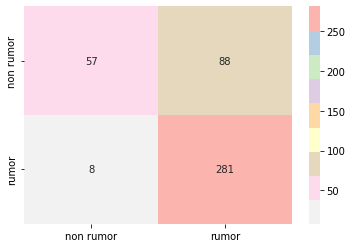

In [ ]:
etc_conmat = confusion_matrix(label_test, etc_predictions)
print("Confusion Matrix for Extra Trees Classifer: " + "\n" , etc_conmat)

heatmap(etc_conmat , cmap="Pastel1_r", xticklabels=['non rumor' ,'rumor'], yticklabels=['non rumor' ,'rumor'], annot=True, fmt='g')

In [ ]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(Vectorizer1, etc)
rumor_df.post.iloc[0]
print(pipe.predict_proba([rumor_df.post.iloc[0]]))
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=["non rumor", "rumor"])
max_features = rumor_df.post.str.split().map(lambda x: len(x)).max() 
print("Maximum number of features: ", max_features)
import random
random.seed(20)
idx = random.randint(0, len(rumor_df))
exp4 = explainer.explain_instance(
    rumor_df.post.iloc[idx], pipe.predict_proba, num_features=7
    
)
print(f"Explanation as a list of weighted features: ")
exp4.as_list()

[[0.05222297 0.94777703]]
Maximum number of features:  29
Explanation as a list of weighted features: 


[('seven', -0.004519396181691275),
 ('picture', 0.0017330623134252563),
 ('according', 0.0016881632982318263),
 ('URL', -0.0014538138608794233),
 ('gunman', 0.001394799107267328),
 ('a', 0.00013382778996843327),
 ('to', 0.0001285222826677127)]

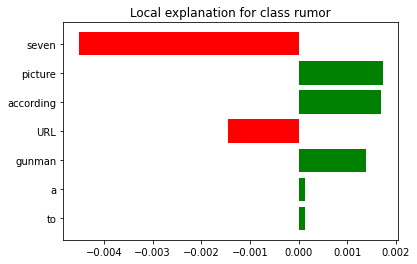

In [ ]:
plot = exp4.as_pyplot_figure()

In [ ]:
exp4.show_in_notebook(text=False)

In [11]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth = 300, criterion = 'gini')
dt.fit(data_train,label_train)
label_pred1 = dt.predict(data_test)
dt_predictions = [round(value) for value in label_pred1]

In [12]:
#evaluate predictions

#accuracy
dt_accuracy = accuracy_score(label_test, dt_predictions)
print("Accuracy using DT: %.2f%%" % (dt_accuracy * 100.0))

#recall
from sklearn.metrics import recall_score
dt_recall = recall_score(label_test, dt_predictions)
print("Recall for DT: ", dt_recall)

#precision
from sklearn.metrics import precision_score
dt_precision = precision_score(label_test, dt_predictions, average=None)
print("Precision for DT: ", dt_precision)

#F1 Score
from sklearn.metrics import f1_score
dt_f1score = f1_score(label_test, dt_predictions, average=None)
print("F1 Score for DT: ", dt_f1score)

#manual f1 score
dt_F1 = 2* (dt_precision * dt_recall) / (dt_precision + dt_recall)
print("Manual F1 score for DT: ", dt_F1)

Accuracy using DT: 76.27%
Recall for DT:  0.8858131487889274
Precision for DT:  [0.69444444 0.78527607]
F1 Score for DT:  [0.59288538 0.83252033]
Manual F1 score for DT:  [0.77854145 0.83252033]


Confusion Matrix for Decision Tree: 
 [[ 75  70]
 [ 33 256]]


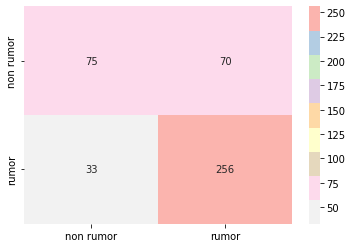

In [14]:
dt_conmat = confusion_matrix(label_test, dt_predictions)
print("Confusion Matrix for Decision Tree: " + "\n" , dt_conmat)

heatmap(dt_conmat , cmap="Pastel1_r", xticklabels=['non rumor' ,'rumor'], yticklabels=['non rumor' ,'rumor'], annot=True, fmt='g')

In [ ]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(Vectorizer1, dt)
rumor_df.post.iloc[0]
print(pipe.predict_proba([rumor_df.post.iloc[0]]))
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=["non rumor", "rumor"])
max_features = rumor_df.post.str.split().map(lambda x: len(x)).max() 
print("Maximum number of features: ", max_features)
import random
random.seed(20)
idx = random.randint(0, len(rumor_df))
exp5 = explainer.explain_instance(
    rumor_df.post.iloc[idx], pipe.predict_proba, num_features=7
    
)
print(f"Explanation as a list of weighted features: ")
exp5.as_list()


[[0. 1.]]
Maximum number of features:  29
Explanation as a list of weighted features: 


[('picture', 0.04061343774470112),
 ('seven', 0.038049004702128825),
 ('gunman', 0.03771410602748063),
 ('according', 0.037305812151758266),
 ('URL', -0.03703075888661562),
 ('to', 0.00408934373555416),
 ('of', 0.0031118942766546294)]

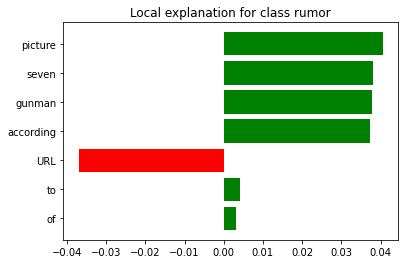

In [ ]:
plot = exp5.as_pyplot_figure()


In [ ]:
exp5.show_in_notebook(text=False)

In [ ]:
from sklearn.metrics import classification_report
print("Classification report for XGBoost: " + "\n" , classification_report(label_test, xgb_predictions))
print("Classification report for SVM: " + "\n", classification_report(label_test, svc_predictions))
print("Classification report for Random Forest: " + "\n" , classification_report(label_test, rf_predictions))
print("Classification report for Extra Trees Classifer: " + "\n" , classification_report(label_test, etc_predictions))
print("Classification report for Decision Tree: " + "\n" , classification_report(label_test, dt_predictions))

Classification report for XGBoost: 
               precision    recall  f1-score   support

           0       0.73      0.64      0.68       145
           1       0.83      0.88      0.86       289

    accuracy                           0.80       434
   macro avg       0.78      0.76      0.77       434
weighted avg       0.80      0.80      0.80       434

Classification report for SVM: 
               precision    recall  f1-score   support

           0       0.84      0.55      0.67       145
           1       0.81      0.95      0.87       289

    accuracy                           0.82       434
   macro avg       0.83      0.75      0.77       434
weighted avg       0.82      0.82      0.80       434

Classification report for Random Forest: 
               precision    recall  f1-score   support

           0       0.93      0.29      0.44       145
           1       0.74      0.99      0.84       289

    accuracy                           0.76       434
   macro avg   